## Satellite image segmentation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from mxnet.gluon.data import Dataset, DataLoader
from mxnet.gluon.loss import Loss
from mxnet import image

### Data preparation

In [3]:
from skimage.io import imsave, imread
from datetime import datetime
import collections

In [4]:
geopedia_layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905'}

In [35]:
class ImageWithMaskDataset(Dataset):
    """
    A dataset for loading images (with masks).
    Based on: mxnet.incubator.apache.org/tutorials/python/data_augmentation_with_masks.html
    
    Parameters
    ----------
    root : str
        Path to root directory.
    transform : callable, default None
        A function that takes data and label and transforms them:
    ::
        transform = lambda data, label: (data.astype(np.float32)/255, label)
    """
    def __init__(self, root, transform=None):
        self._root = os.path.expanduser(root)
        self._transform = transform
        self._exts = ['.png']
        self._list_images(self._root)

    def _list_images(self, root):
        images = collections.defaultdict(dict)
        for filename in sorted(os.listdir(root)):
            name, ext = os.path.splitext(filename)
            mask_flag = "geopedia" in name
            if ext.lower() not in self._exts:
                continue
            if not mask_flag:
                patch_id = filename.split('_')[1]
                year = datetime.strptime(filename.split('_')[3], "%Y%m%d-%H%M%S").year
                mask_fn = 'tulip_{}_geopedia_{}.png'.format(patch_id, geopedia_layers['tulip_field_{}'.format(year)])
                images[name]["base"] = filename
                images[name]["mask"] = mask_fn
        self._image_list = list(images.values())

    def __getitem__(self, idx):
        assert 'base' in self._image_list[idx], "Couldn't find base image for: " + image_list[idx]["mask"]
        base_filepath = os.path.join(self._root, self._image_list[idx]["base"])
        base = mx.image.imread(base_filepath)
        assert 'mask' in self._image_list[idx], "Couldn't find mask image for: " + image_list[idx]["base"]
        mask_filepath = os.path.join(self._root, self._image_list[idx]["mask"])
        mask = mx.image.imread(mask_filepath, flag=0)
        if self._transform is not None:
            return self._transform(base, mask)
        else:
            return base, mask

    def __len__(self):
        return len(self._image_list)

In [6]:
def positional_augmentation(joint):
    # Random crop
    crop_height = img_height
    crop_width  = img_width
    aug = mx.image.RandomCropAug(size=(crop_width, crop_height)) # Watch out: weight before height in size param!
    aug_joint = aug(joint)
    # Horizontal flip (50% probability)
    aug = mx.image.HorizontalFlipAug(0.5)
    aug_joint = aug(aug_joint)
    return aug_joint


def color_augmentation(base):
    # Only applied to the base image, and not the mask layers.
    aug = mx.image.ColorJitterAug(brightness=0.2, contrast=0.2, saturation=0)
    aug_base = aug(base)
    return aug_base


def joint_transform(base, mask):
    ### Convert types
    base = base.astype('float32')/255
    mask = mask.astype('float32')/255
    
    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = mx.nd.concat(base, mask, dim=2)

    ### Augmentation Part 1: positional
    aug_joint = positional_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    ### Augmentation Part 2: color
    aug_base = color_augmentation(aug_base)
    
    # Reshape the tensors so the order is now (channels, w, h)
    aug_base =  mx.nd.transpose(aug_base, (2,0,1))
    aug_mask =  mx.nd.transpose(aug_mask, (2,0,1))
    
    return aug_base, aug_mask

###  U-Net

In [7]:
def conv_block(channels, kernel_size):
    out = nn.HybridSequential()
    out.add(
        nn.Conv2D(channels, kernel_size, padding=1, use_bias=False),
        nn.BatchNorm(),
        nn.Activation('relu')
    )
    return out

In [8]:
def down_block(channels):
    out = nn.HybridSequential()
    out.add(
        conv_block(channels, 3),
        conv_block(channels, 3)
    )
    return out

In [9]:
class up_block(nn.HybridBlock):
    def __init__(self, channels, shrink=True, **kwargs):
        super(up_block, self).__init__(**kwargs)
        self.upsampler = nn.Conv2DTranspose(channels=channels, kernel_size=4, strides=2, 
                                            padding=1, use_bias=False)
        self.conv1 = conv_block(channels, 1)
        self.conv3_0 = conv_block(channels, 3)
        if shrink:
            self.conv3_1 = conv_block(int(channels/2), 3)
        else:
            self.conv3_1 = conv_block(channels, 3)
    def hybrid_forward(self, F, x, s):
        x = self.upsampler(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.Crop(*[x,s], center_crop=True)
        x = s + x
        x = self.conv3_0(x)
        x = self.conv3_1(x)
        return x

In [10]:
class Unet(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(Unet, self).__init__(**kwargs)
        with self.name_scope():
            self.d0 = down_block(64)
            
            self.d1 = nn.HybridSequential()
            self.d1.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(128))
            
            self.d2 = nn.HybridSequential()
            self.d2.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(256))
            
            self.d3 = nn.HybridSequential()
            self.d3.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(512))
            
            self.d4 = nn.HybridSequential()
            self.d4.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(1024))
            
            self.u3 = up_block(512, shrink=True)
            self.u2 = up_block(256, shrink=True)
            self.u1 = up_block(128, shrink=True)
            self.u0 = up_block(64, shrink=False)
            
            self.conv = nn.Conv2D(2,1)
    def hybrid_forward(self, F, x):
        x0 = self.d0(x)
        x1 = self.d1(x0)
        x2 = self.d2(x1)
        x3 = self.d3(x2)
        x4 = self.d4(x3)

        y3 = self.u3(x4,x3)
        y2 = self.u2(y3,x2)
        y1 = self.u1(y2,x1)
        y0 = self.u0(y1,x0)
        
        out = self.conv(y0)
        
        return out

### Loss

The IoU metric tends to have a "squaring" effect on the errors relative to the Dice score (aka F score). So the F score tends to measure something closer to average performance, while the IoU score measures something closer to the worst case performance.

https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou

As we are not very confident on the quality of the training data/ground truth, lets go for the Dice coeff

In [11]:
def dice_coef_loss(y_true, y_pred):
    # TODO: Check if axis=[2,3] is correct (in the OG example it was axis=1)
    intersection = nd.sum((y_true * y_pred), axis=[2,3])
    return -(2. * intersection + 1.)/(nd.sum(y_true, axis=[2,3]) + nd.sum(y_pred, axis=[2,3]) + 1.)

In [12]:
class DiceCoeffLoss(Loss):
    """
    Dice loss coefficient.
    Input:
        Tensor of size (batch_size, 1, width, height)
    Output:
        Loss tensor with shape (batch size) 
    """

    def __init__(self, smooth=1.0, _axis=[1,2,3], _weight = None, _batch_axis= 0, **kwards):
        Loss.__init__(self, weight=_weight, batch_axis=_batch_axis, **kwards)

        with self.name_scope():
            self.smooth = smooth
            self.axis = _axis

    def hybrid_forward(self, F, label, pred):
        assert label.shape[1] == 1, 'Incorrect dimensions for label: {}'.format(label.shape)
        assert pred.shape[1]  == 1, 'Incorrect dimensions for prediction: {}'.format(pred.shape)
        intersect = nd.sum((label * pred), axis=self.axis)
        dice = -(2. * intersect + self.smooth)/(nd.sum(label, axis=self.axis) + nd.sum(pred, axis=self.axis) + self.smooth)
        return dice

In [13]:
# Not in use right now, keeping it here in case it's useful in the future
# def iou(a, b):
#     i = nd.sum((a==1)*(b==1),axis=[2,3])
#     u = nd.sum(a,axis=[2,3]) + nd.sum(b, axis=[2,3]) - i
#     return (i+1)/(u+1)

### Evaluation metric

In [14]:
class DiceCoeffMetric(mx.metric.EvalMetric):
    """Stores a moving average of the dice coeff"""
    def __init__(self):
        super(DiceCoeffMetric, self).__init__('DiceCoeff')
        self.num = 1
        self.name = ['Dice coefficient']
        self.reset()

    def reset(self):
        """
        override reset behavior
        """
        if getattr(self, 'num', None) is None:
            self.num_inst = 0
            self.sum_metric = 0.0
        else:
            self.num_inst = [0] * self.num
            self.sum_metric = [0.0] * self.num

    def update(self, loss):
        """
        Implementation of updating metrics
        """
        self.sum_metric += nd.sum(loss)
        self.num_inst += loss.shape[0]

        
    def get(self):
        """Get the current evaluation result.
        Override the default behavior

        Returns
        -------
        name : str
           Name of the metric.
        value : float
           Value of the evaluation.
        """
        if self.num is None:
            if self.num_inst == 0:
                return (self.name, float('nan'))
            else:
                return (self.name, self.sum_metric / self.num_inst)
        else:
            names = ['%s'%(self.name[i]) for i in range(self.num)]
            values = [x / y if y != 0 else float('nan') \
                for x, y in zip(self.sum_metric, self.num_inst)]            
            return (names, values)

In [15]:
def metric_str(names, vals):
    return ', '.join(['%s=%f'%(name, val) for name, acc in zip(names, vals)])

### Training

In [16]:
def evaluate_loss(data_iterator, net):
    dice = DiceCoeffLoss()
    metric = DiceCoeffMetric()
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # data = color_normalize(data/255, mean, std)
        output = net(data)
        # prediction = mx.nd.argmax(output, axis=1)
        loss = dice(label, output)
        metric.update(loss)
    return metric.get()[1]

In [33]:
def train_util(net, train_iter, val_iter, loss_fn,
               trainer, ctx, epochs, batch_size, checkpoint_dir, init_epoch=0):
    '''
    Function to train the neural network.
    
    PARAMS:
    - net: network to train
    - train_iter: gluon.data.DataLoader with the training data
    - validation_iter: "                      "  validation data
    - loss_fn: loss function to use for training
    - trainer: gluon.Trainer to use for training
    - ctx: context where we will operate (GPU or CPU)
    - epochs: number of epochs to train for
    - batch_size
    - checkpoint_dir: directory where checkpoints are saved every 100 batches
    - init_epoch: set to the initial epoch in case training is resumed from a previous execution'''
    
    res = {'train':[],'valid':[]}
    for epoch in range(1 + init_epoch, epochs + init_epoch+1):
        metric = DiceCoeffMetric()
        for i, (data, label) in enumerate(train_iter):
            st = time.time()
            # Ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Normalize images?
            # data = color_normalize(data/255, mean, std)
            
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(label, output)

            loss.backward()
            trainer.step(data.shape[0], ignore_stale_grad=True)
            
            #  Keep a moving average of the losses
            metric.update(loss)
            names, vals = metric.get()
            if i%5 == 0:
                print('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(epoch, i, batch_size/(time.time()-st), metric_str(names, vals)))
                           
        net.save_params('%s/%d-%d.params'%(checkpoint_dir, epoch))
        names, train_acc = metric.get()
        validation_acc = evaluate_loss(val_iter, net)
        res['train'].append(train_acc)
        res['valid'].append(validation_acc)
        print("Epoch %s | training_acc %s | val_acc %s " % (epoch, train_acc, validation_acc))
        metric.reset()
        
    return res

### Run

In [18]:
ctx = mx.cpu()

In [19]:
batch_size = 8
img_width  = 224
img_height = 224
#data_shape = (batch_size, 1, img_width, img_height)

Create a DataLoader from our Dataset

In [37]:
imgdir = '../data/tulips/bloom/16/'
train_ds = ImageWithMaskDataset(imgdir , transform=joint_transform)
train_iter = gluon.data.DataLoader(train_ds, batch_size)

In [38]:
# TODO: CREATE DIFFERENT TRAIN AND VAL SETS
val_ds  = ImageWithMaskDataset(imgdir , transform=joint_transform)
val_iter= gluon.data.DataLoader(val_ds, batch_size)

In [22]:
def plot_mx_arrays(arrays):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    plt.subplots(figsize=(14, 8))
    for idx, array in enumerate(arrays):
        assert array.shape[2] == 3, "RGB Channel should be last"
        plt.subplot(1, 2, idx+1)
        plt.imshow(array.asnumpy())

In [39]:
sample = val_ds.__getitem__(222)
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')

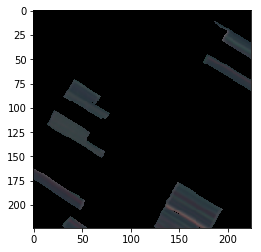

In [12]:
# plt.imshow((sample_base*sample_mask).asnumpy())

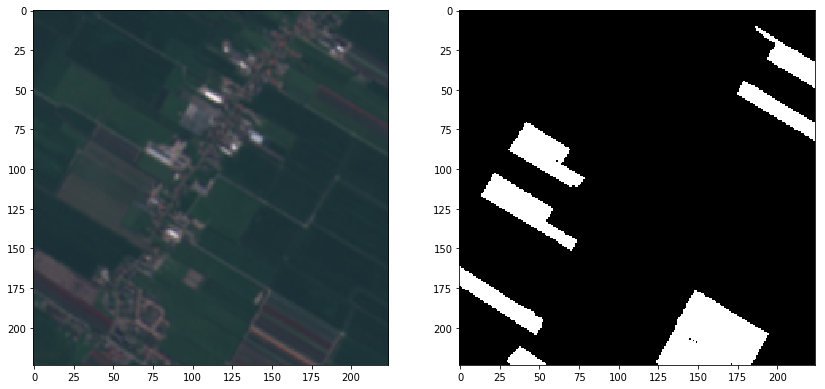

In [13]:
# plot_mx_arrays([sample_base, sample_mask])

In [24]:
net = Unet()

In [25]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
net.hybridize()

In [26]:
loss = DiceCoeffLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', 
            {'learning_rate': 1e-4, 'beta1':0.9, 'beta2':0.99})

In [27]:
epochs = 20
checkpoint_dir = 'checkpoints'

In [41]:
train_util(net, train_iter, val_iter, loss, trainer, ctx,
           epochs, batch_size, checkpoint_dir)

AssertionError: Incorrect dimensions for prediction: (8, 2, 224, 224)

In [43]:
# Testing purposes
data = nd.reshape(sample_base, (1,3,224,224)).as_in_context(ctx)
a = net(data)

In [48]:
mx.nd.transpose(a[0], (1,2,0))[0,0]


[0.00491475 0.01609789]
<NDArray 2 @cpu(0)>

In [40]:
sample_mask.shape 

(1, 224, 224)